In [1]:
import os
import re
import arff
import numpy as np
import pandas as pd
#from scipy.io import arff
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler


This dataset shows 25 different medical parameters that are related to the Chronic Kidney Disease (CKD). It is expected all these parameters are directly related to some extent to whether someone has CKD or not. However: how do those parameters vary between people with CKD and healthy ones? We will look at the markers people can measure in their homes:


1. Do older people tend to have CKD more often than younger people? 
2. How does blood pressure get modified with CKD? Does it decrease or increase?
3. Do blood glucose levels get altered with CKD?
4. Is appetite affected by CKD?

The aim of this project is to provide a general idea on how these different parameters vary depending on the presence of CKD. This way, this notebook can be used as a didactic source.

Moreover, we will try to apply a machine learning model to see how accurately we can predict if someone is sick (CKD) or healthy (Not CKD). Note that this dataset is not balanced and does not have a large amount of data. Although there are different approaches to treat imbalanced data, this is outside the scope of this project. The ML model will be just a proof of concept to check how well it does given this scenario.

In [3]:
original_dataset = 'chronic_kidney_disease.arff'
final_kidney_ds = 'kidney_data.csv'

with open(final_kidney_ds, 'w') as final:
    with open(original_dataset, 'r') as original:
        for i, row in enumerate(original.readlines()):
            if re.search("^(@attribute) '\w+?' ", row):
                string_to_write = re.search('''^@attribute '(\w+?)' ''', row)
                final.write(string_to_write.group(1)+',') #.group(1) to obtain the captured string by ()
            elif re.search("^[A-Za-z0-9'?]", row):
                    final.write('\n')
                    final.write(row)

In [4]:
df = pd.read_csv(final_kidney_ds)
pd.pandas.set_option('display.max_columns', None) #To display all columns in our datasets
pd.pandas.set_option('display.max_rows', None)

In [5]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class,Unnamed: 25
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd,NaN
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd,NaN
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd,NaN
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd,NaN
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd,NaN


WHat are the dimensions of the dataset?

In [6]:
df.shape

(400, 26)

In [7]:
df.columns.shape

(26,)

The dataset has an extra column with no data due to the transformation process from arff to csv:

In [8]:
del df[df.columns[-1]]

In [9]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,36,1.2,?,?,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,18,0.8,?,?,11.3,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,?,?,9.6,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,?,?,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [10]:
new_column_names = ['age', 'blood_pres', 'specif_grav', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell', 'pus_cell_clumps',
                    'bacteria', 'blood_gluc_random', 'blood_urea', 'ser_creatinine', 'Na', 'K', 'hemoglobin', 'pack_cell_vol',
                    'white_blood_cell_count', 'red_blood_cell_count', 'hypertension', 'diabetes',
                    'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', 'label']

col_dict = dict(zip(df.columns, new_column_names))
df.rename(columns=col_dict, inplace=True)

In [11]:
df.dtypes

age                        object
blood_pres                 object
specif_grav                object
albumin                    object
sugar                      object
red_blood_cells            object
pus_cell                   object
pus_cell_clumps            object
bacteria                   object
blood_gluc_random          object
blood_urea                 object
ser_creatinine             object
Na                         object
K                          object
hemoglobin                 object
pack_cell_vol              object
white_blood_cell_count     object
red_blood_cell_count       object
hypertension               object
diabetes                   object
coronary_artery_disease    object
appetite                   object
pedal_edema                object
anemia                     object
label                      object
dtype: object

In [12]:
df.replace('?', np.nan, inplace=True)

In [13]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,36,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,18,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,53,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,26,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [14]:
def change_str_to_float(df):
    for column in df.columns:
        #check for appropriate columns
        if df[column].dtype == 'O':
            #checking for numbers in columns
            check = df[column].str.contains('^[0-9]')
            if check.any():
                df[column] = df[column].astype('float64')

In [15]:
change_str_to_float(df)

In [16]:
df.dtypes

age                        float64
blood_pres                 float64
specif_grav                float64
albumin                    float64
sugar                      float64
red_blood_cells             object
pus_cell                    object
pus_cell_clumps             object
bacteria                    object
blood_gluc_random          float64
blood_urea                 float64
ser_creatinine             float64
Na                         float64
K                          float64
hemoglobin                 float64
pack_cell_vol              float64
white_blood_cell_count     float64
red_blood_cell_count       float64
hypertension                object
diabetes                    object
coronary_artery_disease     object
appetite                    object
pedal_edema                 object
anemia                      object
label                       object
dtype: object

In [17]:
df.isna().any()

age                         True
blood_pres                  True
specif_grav                 True
albumin                     True
sugar                       True
red_blood_cells             True
pus_cell                    True
pus_cell_clumps             True
bacteria                    True
blood_gluc_random           True
blood_urea                  True
ser_creatinine              True
Na                          True
K                           True
hemoglobin                  True
pack_cell_vol               True
white_blood_cell_count      True
red_blood_cell_count        True
hypertension                True
diabetes                    True
coronary_artery_disease     True
appetite                    True
pedal_edema                 True
anemia                      True
label                      False
dtype: bool

In [18]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [19]:
print('Number of instances with null values: {} ; Number of columns with null values: {}'.format(df.isna().any(axis=1).sum(),
                                                                                                df.isna().any().sum()))

Number of instances with null values: 243 ; Number of columns with null values: 24


In [20]:
for column in df.columns:
    #check for appropriate columns
    if df[column].dtype == 'O':
        print(df[column].value_counts())

normal      201
abnormal     47
Name: red_blood_cells, dtype: int64
normal      259
abnormal     76
Name: pus_cell, dtype: int64
notpresent    354
present        42
Name: pus_cell_clumps, dtype: int64
notpresent    374
present        22
Name: bacteria, dtype: int64
no     251
yes    147
Name: hypertension, dtype: int64
no      260
yes     136
 yes      1
Name: diabetes, dtype: int64
no     364
yes     34
Name: coronary_artery_disease, dtype: int64
good    316
poor     82
no        1
Name: appetite, dtype: int64
no      322
yes      76
good      1
Name: pedal_edema, dtype: int64
no     339
yes     60
Name: anemia, dtype: int64
ckd       248
notckd    149
ckd\t       2
no          1
Name: label, dtype: int64


We can see that diabetes", "appetite", "pedal_edema" and "label" have misslabeled instances. Let's fix it:

In [21]:
df.diabetes.replace((' yes'), ('yes'), inplace=True)
df.appetite.replace(('no'), ('poor'), inplace=True)
df.pedal_edema.replace(('good'), ('no'), inplace=True) #replace "good" for "no" because it is good not having pedal edema
df.label.replace(('ckd\t', 'no'), ('ckd', 'notckd'), inplace=True)

In [22]:
for column in df.columns:
    #check for appropriate columns
    if df[column].dtype == 'O':
        print(df[column].value_counts())

normal      201
abnormal     47
Name: red_blood_cells, dtype: int64
normal      259
abnormal     76
Name: pus_cell, dtype: int64
notpresent    354
present        42
Name: pus_cell_clumps, dtype: int64
notpresent    374
present        22
Name: bacteria, dtype: int64
no     251
yes    147
Name: hypertension, dtype: int64
no     260
yes    137
Name: diabetes, dtype: int64
no     364
yes     34
Name: coronary_artery_disease, dtype: int64
good    316
poor     83
Name: appetite, dtype: int64
no     323
yes     76
Name: pedal_edema, dtype: int64
no     339
yes     60
Name: anemia, dtype: int64
ckd       250
notckd    150
Name: label, dtype: int64


In [23]:
df.label.value_counts()

ckd       250
notckd    150
Name: label, dtype: int64

So we can see that more than half of our samples have null values and all but one feature also has null values. Let's start first by droping those instances where we have null values. Since many of our columns are categorical in order to impute those Nan values we would have to make a specific approach that its not necessary for the scope of this project. 

Our dataset will be highly shrinked, but for our analysis purposes to learn how the diferent features behave is enough. However, it is true that the prediction model may not be very accurate. However, let's do that for a first approximation to see the potential of this dataset.

In [24]:
df_c = df.copy(deep=True) #lets make a copy of the dataframe

In [25]:
df.dropna(axis=0, inplace=True)

In [26]:
df.replace(['ckd', 'notckd' ], [1,0], inplace=True)

In [27]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1


In [28]:
df.label.value_counts()

0    114
1     43
Name: label, dtype: int64

We see that our dataset is not balanced even after dropping rows with null values. This finding together with the fact that we have few instances points towardsa probably not very reliable model: more data and a more balanced dataset may be needed to predict chronic kidney disease accurately. However, let's take this to the its maximum capability and check what we get. There are different approaches to treat imbalanced datasets that will not be covered in this project.

First of all, lets explore our dataset further to get some insights. 

In [29]:
df.describe()

,age,blood_pres,specif_grav,albumin,sugar,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,label
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.00000,157.000000,157.000000
mean,49.401274,74.076433,1.019873,0.802548,0.254777,131.496815,52.605096,2.197452,138.815287,4.643949,13.687898,41.891720,8464.33121,4.892357,0.273885
std,15.427190,11.206421,0.005517,1.416204,0.815746,65.118297,47.545627,3.085449,7.501984,3.486280,2.891419,9.128414,3133.46316,1.022600,0.447378
min,6.000000,50.000000,1.005000,0.000000,0.000000,70.000000,10.000000,0.400000,111.000000,2.500000,3.100000,9.000000,3800.00000,2.100000,0.000000
25%,39.000000,60.000000,1.020000,0.000000,0.000000,97.000000,26.000000,0.700000,135.000000,3.700000,12.600000,37.000000,6500.00000,4.500000,0.000000
50%,50.000000,80.000000,1.020000,0.000000,0.000000,117.000000,39.000000,1.100000,139.000000,4.500000,14.300000,44.000000,7800.00000,5.000000,0.000000
75%,60.000000,80.000000,1.025000,1.000000,0.000000,132.000000,50.000000,1.700000,144.000000,4.900000,15.800000,48.000000,9700.00000,5.600000,1.000000
max,83.000000,110.000000,1.025000,4.000000,5.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000,54.000000,26400.00000,8.000000,1.000000


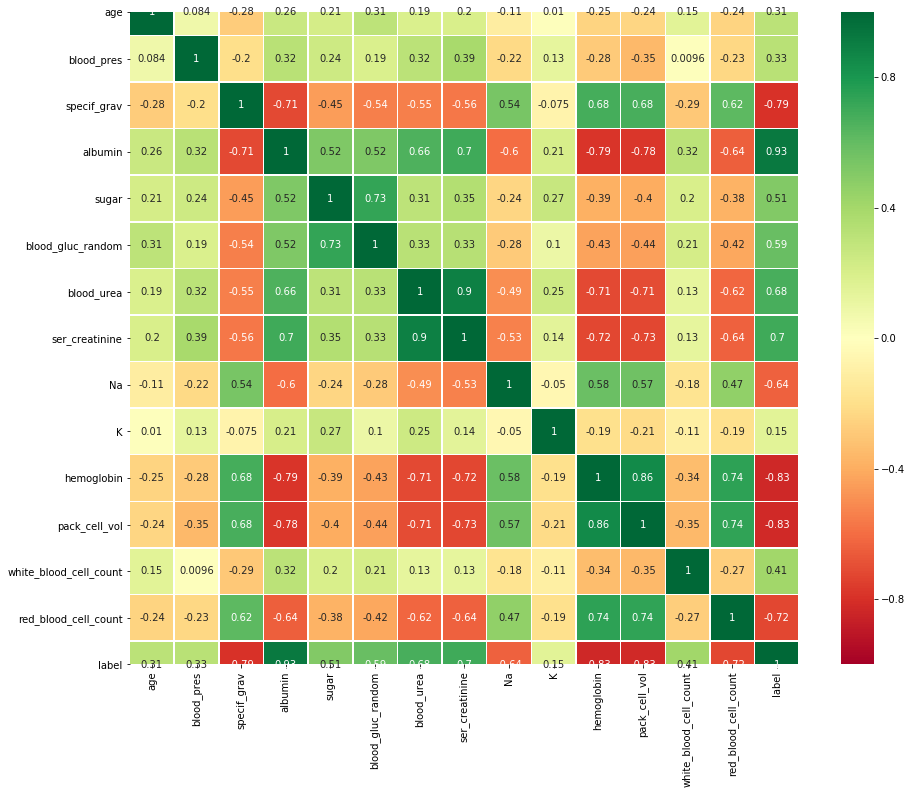

In [30]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, linewidths= 0.5, vmin=-1, vmax=1, cmap='RdYlGn')

In [31]:
no_positives, no_negatives = df[df.label == 1].label.count(), df[df.label == 0].label.count()

healthy_mask= df.label == 0
sick_mask = df.label == 1

In [32]:
df.columns

Index(['age', 'blood_pres', 'specif_grav', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_gluc_random', 'blood_urea', 'ser_creatinine', 'Na', 'K',
       'hemoglobin', 'pack_cell_vol', 'white_blood_cell_count',
       'red_blood_cell_count', 'hypertension', 'diabetes',
       'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia',
       'label'],
      dtype='object')

### How is age important when predicting CKD?

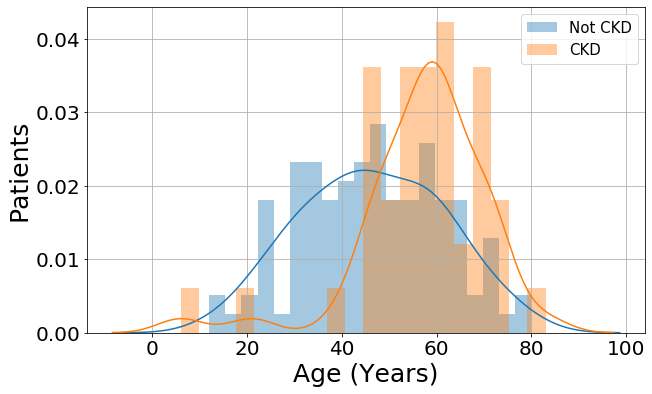

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

sns.distplot(df[df.label==0].age, bins=20, kde=True, hist=True, label='Not CKD')
sns.distplot(df[df.label==1].age, bins=20, kde=True, hist=True, label='CKD')

ax.grid(True)

ax.set_xlabel('Age (Years)', fontsize=25)
ax.set_ylabel('Patients', fontsize=25)
ax.tick_params(axis='both', labelsize=20)

ax.legend(fontsize=15)

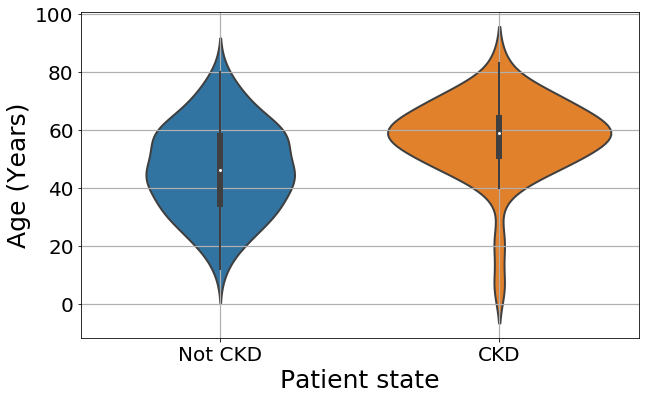

In [34]:
fig, ax = plt.subplots(figsize=(10,6))


sns.violinplot(data=df, y='age', x='label', linewidth=2, inner='box')

ax.set_xticklabels(('Not CKD', 'CKD'))

#ax.set_title('Age distribution', fontsize= 30)

ax.set_xlabel('Patient state', fontsize=25)
ax.set_ylabel('Age (Years)', fontsize=25)
ax.tick_params(axis='both', labelsize=20)

plt.grid(True, linewidth=1.2)

plt.savefig('./age_violin.jpg', quality=100)




In [35]:
print('Mean age of healthy people is: {} years. Mean age of sick people {} years'.format(df[df.label==0].age.mean(), df[df.label==1].age.mean()))

Mean age of healthy people is: 46.42982456140351 years. Mean age of sick people 57.27906976744186 years


Given our (limited) amount of data we can see the age distribution is shifted towards ages > 45 years old, while younger people does not usually have CKD. The healthy people distribution is more evenly distributed. 


## Hemoglobin:

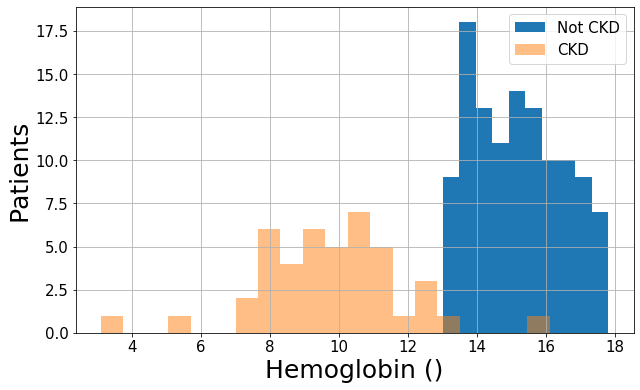

In [36]:
hemo_negatives_hist = df[(df.label == 0)].hemoglobin
hemo_positives_hist = df[(df.label == 1)].hemoglobin

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(hemo_negatives_hist, bins=10, stacked=False, label='Not CKD')
ax.hist(hemo_positives_hist, bins=20, stacked=False, label='CKD', alpha=.5)



ax.grid(True)

ax.set_xlabel('Hemoglobin ()', fontsize=25)
ax.set_ylabel('Patients', fontsize=25)
ax.tick_params(axis='both', labelsize=15)

ax.legend(fontsize=15)

plt.show()

### Blood pressure:

Let's take the categorical column "hypertension":

In [37]:
#hypertension % on sick people
hpt_positives = df[(df.label == 1) & (df.hypertension == 'yes')]['hypertension'].count()/no_positives
non_hpt_positives = df[(df.label == 1) & (df.hypertension == 'no')]['hypertension'].count()/no_positives

#hypertension & on healthy people
hpt_negatives = df[(df.label == 0) & (df.hypertension == 'yes')]['hypertension'].count()/no_negatives
non_hpt_negatives = df[(df.label == 0) & (df.hypertension == 'no')]['hypertension'].count()/no_negatives

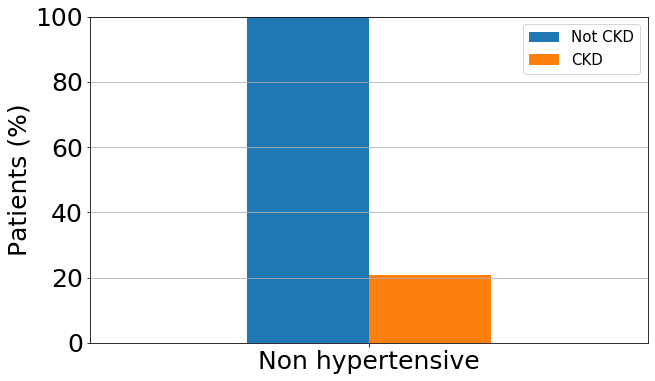

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

#First we set the values (bar height)
x_labels = ['Non hypertensive']



x = np.arange(len(x_labels))
width = 0.35

ax.bar(x=x-width/2, height=[non_hpt_negatives*100], width=width, label='Not CKD')
ax.bar(x=x+width/2, height=[non_hpt_positives*100], width=width, label='CKD')

ax.set_xticks(x) 
ax.set_xticklabels(x_labels) 
ax.tick_params(axis='both', labelsize=25)

ax.set_ylim(0,100)
ax.set_xlim(-0.8,0.8)
ax.set_ylabel('Patients (%)', fontsize=25)

ax.yaxis.grid(True)

ax.legend(fontsize=15)

plt.savefig('./hypertension_bar.jpg', quality=100)

We can see that people without CKD do not show any hypertension while almost 80% of our sample with CKD has hypertension. There is also another feature in our dataset that corresponds to blood pressure ("blood_pres").

In [39]:
df.blood_pres.head(3)

3     70.0
9     90.0
11    70.0
Name: blood_pres, dtype: float64

Each instance is only made up by one number (while blood pressure must be defined by two components: diastolic (or low) and systolic (or high) components). Diastolic values can vary between X and 90 mm Hg and systolic between X and 140 mm Hg for a healthy person (WHO link). Let's check the range of our column feature:

In [40]:
print('Minimum value of the "blood_pres" feature: {} mm Hg. \nMaximum value of the "blood_pres" feature: {} mm Hg'.format(
                                                                    df.blood_pres.min(), df.blood_pres.max()))

Minimum value of the "blood_pres" feature: 50.0 mm Hg. 
Maximum value of the "blood_pres" feature: 110.0 mm Hg


This shows us our feature reflects the diastolic component.

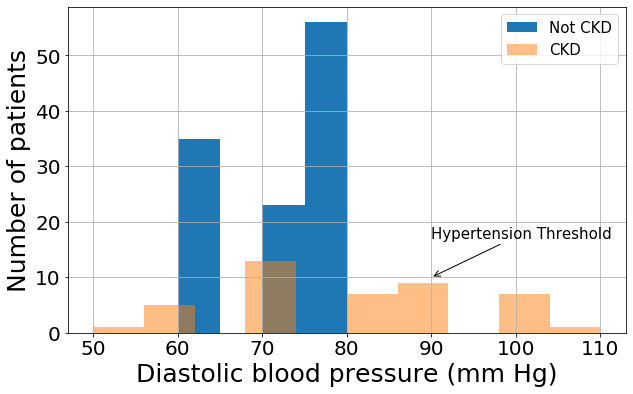

In [41]:
blood_press_neg = df[(df.label == 0)].blood_pres
blood_press_pos = df[(df.label == 1)].blood_pres

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(blood_press_neg, bins=4, stacked=True, label='Not CKD')
ax.hist(blood_press_pos, bins=10, stacked=True, label='CKD', alpha=.5)


ax.annotate("Hypertension Threshold",
            xy=(90, 10), xycoords='data',
            xytext=(90, 17), textcoords='data', fontsize=15,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )


ax.grid(True)

ax.set_xlabel('Diastolic blood pressure (mm Hg)', fontsize=25)
ax.set_ylabel('Number of patients', fontsize=25)
ax.tick_params(axis='both', labelsize=20)

ax.legend(fontsize=15)

plt.savefig('./blood_pressure_bar.jpg', quality=100)

plt.show()


In [42]:
diastolic_hypertension_percentage = df[(df.label == 1) & (df.blood_pres >= 90)].blood_pres.count()/no_positives * 100
print('People with CKD that have a high diastolic blood pressure value: {:2.2f} %'.format(diastolic_hypertension_percentage))

People with CKD that have a high diastolic blood pressure value: 39.53 %


We can see that only ~40% of sick people have a higher than normal diastolic blood pressure, while we know that ~80% have hypertension. This implies that people with normal values of diastolic blood pressure but higher than normal systolic values are also categorized as having hypertension. Thus, as long as one of the two blood pressure components are higher than normal the patient is considered to have hypertension.

## Blood Glucose

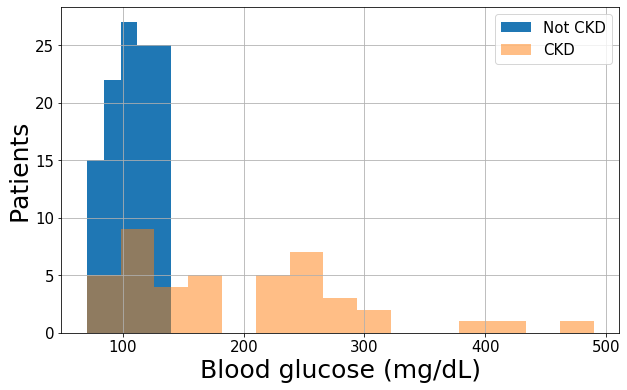

In [43]:
blood_gluc_neg = df[healthy_mask].blood_gluc_random
blood_gluc_pos = df[sick_mask].blood_gluc_random

fig, ax = plt.subplots(figsize=(10,6))

ax.hist(blood_gluc_neg, bins=5, stacked=False, label='Not CKD')
ax.hist(blood_gluc_pos, bins=15, stacked=False, label='CKD', alpha=.5)


ax.grid(True)

ax.set_xlabel('Blood glucose (mg/dL)', fontsize=25)
ax.set_ylabel('Patients', fontsize=25)
ax.tick_params(axis='both', labelsize=15)

ax.legend(fontsize=15)

plt.show()

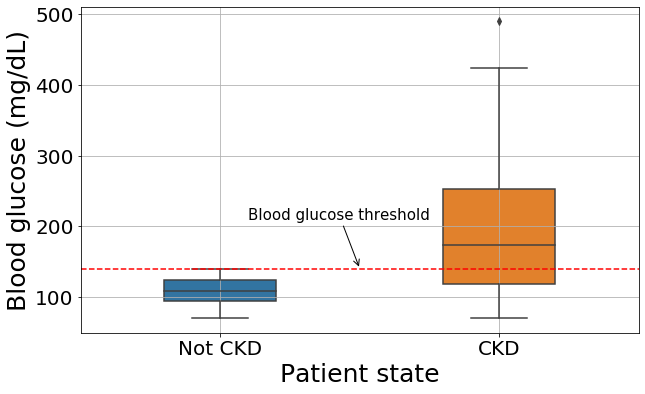

In [44]:
fig, ax = plt.subplots(figsize=(10,6))


sns.boxplot(data=df, x='label', y='blood_gluc_random', width=0.4)

ax.set_xticklabels(('Not CKD', 'CKD'))

ax.set_xlabel('Patient state', fontsize=25)
ax.set_ylabel('Blood glucose (mg/dL)', fontsize=25)
ax.tick_params(axis='both', labelsize=20)

plt.grid(True)
ax.axhline(y=140, c='r', linestyle='--')

ax.annotate("Blood glucose threshold",
            xy=(0.5, 140), xycoords='data',
            xytext=(0.1, 210), textcoords='data', fontsize=15,
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )


plt.savefig('./blodd_glucose_box.jpg', quality=100)


In [45]:
diabetes_percentage = df[(df.label == 1) & (df.blood_gluc_random >= 140)].blood_gluc_random.count()/no_positives * 100
print('People with glucose higher than 140 mg/dL: {:2.2f} %'.format(diabetes_percentage))

People with glucose higher than 140 mg/dL: 58.14 %


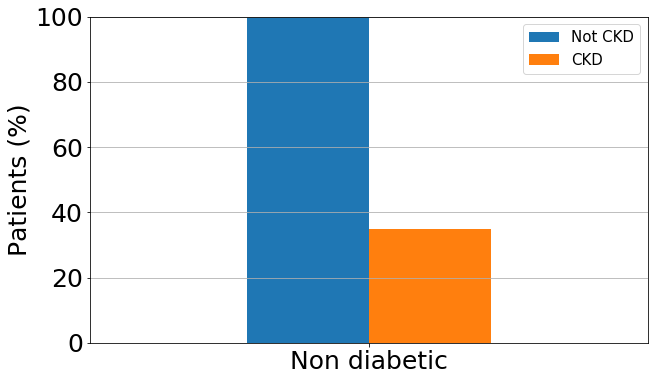

In [46]:
#Diabetes % on sick people
diabetes_positives = df[(df.label == 1) & (df.diabetes == 'yes')]['diabetes'].count()/no_positives
non_diabetes_positives = df[(df.label == 1) & (df.diabetes == 'no')]['diabetes'].count()/no_positives

#Diabetes % on healthy people
diabetes_negatives = df[(df.label == 0) & (df.diabetes == 'yes')]['diabetes'].count()/no_negatives
non_diabetes_negatives = df[(df.label == 0) & (df.diabetes == 'no')]['diabetes'].count()/no_negatives


fig, ax = plt.subplots(figsize=(10,6))

#First we set the values (bar height)
x_labels = ['Non diabetic']

x = np.arange(len(x_labels))
width = 0.35

ax.bar(x=x-width/2, height=[non_diabetes_negatives*100], width=width, label='Not CKD')
ax.bar(x=x+width/2, height=[non_diabetes_positives*100], width=width, label='CKD')

ax.set_xticks(x) 
ax.set_xticklabels(x_labels) 
ax.tick_params(axis='both', labelsize=25)
ax.set_ylim(0,100)
ax.set_xlim(-0.8,0.8)
ax.set_ylabel('Patients (%)', fontsize=25)

ax.yaxis.grid(True)

ax.legend(fontsize=15)

plt.savefig('./diabetes_bar.jpg', quality=100)


In [47]:
df[(df.label == 1) & (df.appetite == 'good')]['appetite'].count()/no_positives

0.5581395348837209

## Appetite:

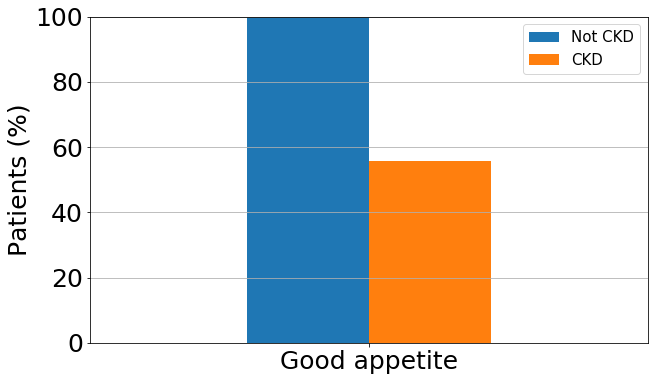

In [48]:
#Appetite % on sick people
good_appetite_positives = df[(df.label == 1) & (df.appetite == 'good')]['appetite'].count()/no_positives
bad_appetite_positives = df[(df.label == 1) & (df.appetite == 'poor')]['appetite'].count()/no_positives

#Appetite % on healthy people
good_appetite_negatives = df[(df.label == 0) & (df.appetite == 'good')]['appetite'].count()/no_negatives
bad_appetite_negatives = df[(df.label == 0) & (df.appetite == 'poor')]['appetite'].count()/no_negatives


fig, ax = plt.subplots(figsize=(10,6))

#First we set the values (bar height) 
x_labels = ['Good appetite']


x = np.arange(len(x_labels))
width = 0.35

ax.bar(x=x-width/2, height=[good_appetite_negatives*100], width=width, label='Not CKD')
ax.bar(x=x+width/2, height=[good_appetite_positives*100], width=width, label='CKD')

ax.set_xticks(x)
ax.set_xticklabels(x_labels) 
ax.tick_params(axis='both', labelsize=25)

ax.set_ylim(0,100)
ax.set_xlim(-0.8,0.8)


ax.set_ylabel('Patients (%)', fontsize=25)

ax.yaxis.grid(True)

ax.legend(fontsize=15)

plt.savefig('./appetite_bar.jpg', quality=100)


In [49]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1


## Predicting Chronic Kidney Disease

1. Since our dataset is quite small, we will use simple and, most importantly, **interpretable** classification models: decision tree and logistic regression.

First of all, we will manipulate the data a little bit to be able to feed it to a ML algorithm by one-hot-encoding the categorical data:

In [50]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,1
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,1
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,1
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,1
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,1


In [51]:
df.label.replace([0,1], ['Not_CKD', 'CKD'], inplace=True)

In [52]:
def get_categorical_columns(data):
    categorical_columns = []
    categorical_set = set(np.arange(0,6,1))
    for column in data.columns:
        if data[column].dtype == 'O':
            categorical_columns.append(column)
        elif len(set(data[column].unique())-categorical_set) == 0:
            categorical_columns.append(column)
    return categorical_columns
                


categorical_cols = get_categorical_columns(df)
categorical_cols

['albumin',
 'sugar',
 'red_blood_cells',
 'pus_cell',
 'pus_cell_clumps',
 'bacteria',
 'hypertension',
 'diabetes',
 'coronary_artery_disease',
 'appetite',
 'pedal_edema',
 'anemia',
 'label']

We don't want to encode the target label column:

In [53]:
categorical_cols.pop()
categorical_cols

['albumin',
 'sugar',
 'red_blood_cells',
 'pus_cell',
 'pus_cell_clumps',
 'bacteria',
 'hypertension',
 'diabetes',
 'coronary_artery_disease',
 'appetite',
 'pedal_edema',
 'anemia']

In [54]:
categorical_cols.append('specif_grav')

Let's One-Hot-Encode our data. Note: while for decision trees this is not necessary and Label Enconding could be done instead, we will build a simple model to use for all classification models. 

In [55]:
df_encoded = pd.get_dummies(df, columns=list(set(categorical_cols)-set(['albumin', 'sugar', 'specific_grav'])))
df_encoded.head()

,age,blood_pres,albumin,sugar,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,label,appetite_good,appetite_poor,pus_cell_abnormal,pus_cell_normal,diabetes_no,diabetes_yes,pus_cell_clumps_notpresent,pus_cell_clumps_present,pedal_edema_no,pedal_edema_yes,coronary_artery_disease_no,coronary_artery_disease_yes,specif_grav_1.005,specif_grav_1.01,specif_grav_1.015,specif_grav_1.02,specif_grav_1.025,bacteria_notpresent,bacteria_present,red_blood_cells_abnormal,red_blood_cells_normal,anemia_no,anemia_yes,hypertension_no,hypertension_yes
3,48.0,70.0,4.0,0.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,CKD,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1
9,53.0,90.0,2.0,0.0,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,CKD,0,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1
11,63.0,70.0,3.0,0.0,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,CKD,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1
14,68.0,80.0,3.0,2.0,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,CKD,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1
20,61.0,80.0,2.0,0.0,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,CKD,0,1,1,0,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1


In [56]:
X, y = df_encoded.drop('label', axis=1), df_encoded['label']

In [57]:
y.replace('Not_CKD', 'Not CKD', inplace=True)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)

Now that we have our train and test sets we can start with the ML process.

## Decision tree:

Let's make a search to see what tree_depth and leave_nodes are optimal:

In [59]:
skf = StratifiedKFold(n_splits=5, random_state=10)
skf.get_n_splits(X_train, y_train)

C:\Users\Pablo Vales\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


5

In [60]:
X_train.shape, y_train.shape

((109, 38), (109,))

In [61]:
parameters = {'max_depth':np.arange(1,10), 'max_leaf_nodes':np.arange(2,10)}
tree = DecisionTreeClassifier(criterion='entropy', random_state=10)
grid_search = GridSearchCV(estimator=tree, param_grid=parameters, cv=skf, verbose=1)


grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.9s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=False),
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=10),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             verbose=1)

In [62]:
y_train.value_counts()

Not CKD    79
CKD        30
Name: label, dtype: int64

In [63]:
grid_search.best_params_

{'max_depth': 1, 'max_leaf_nodes': 2}

In [64]:
grid_search.best_score_

0.9727272727272727

In [65]:
y_pred = grid_search.predict(X_test)

In [66]:
accuracy_score(y_test, y_pred)

0.9375

In [67]:
y_test.value_counts()

Not CKD    35
CKD        13
Name: label, dtype: int64

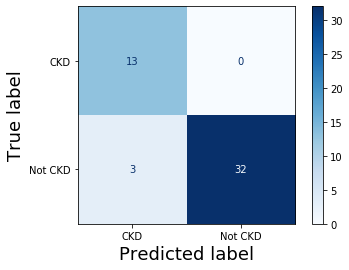

In [68]:
disp = plot_confusion_matrix(grid_search.best_estimator_, X_test, y_test, cmap='Blues')

plt.xticks(fontsize=10)

plt.yticks(fontsize=10)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)

plt.savefig('./conf_mat_dec_tree.png')

In [69]:
y_test.value_counts()

Not CKD    35
CKD        13
Name: label, dtype: int64

In [70]:
export_graphviz(decision_tree=grid_search.best_estimator_,
               out_file='tree_grid.dot', filled=True, 
                feature_names=df_encoded.drop('label', axis=1).columns)

<img src='./tree_grid.PNG' width=30%>

We can see that our accuracy is very good because our data defines very well our labels. However, for a truly reliable model I insist that we must have a larger dataset and ideally, a balanced one. The present cases define almost ideally the symptoms and characteristics of a sick/healthy person, but a larger dataset would add different cases (or exceptions to the general case) that would not fit the decisions made by our tree i.e our model is probably not generalizable. However, this serves our purposes for a toy-model to see its potential.

For the whole dataset:

In [71]:
y_pred_total = grid_search.predict(X)

In [72]:
accuracy_score(y, y_pred_total)

0.9745222929936306

Note that a tree of only depth 1 implies that only 1 variable has been chosen to select whether a patient has CKD or not. This is probably not an ideal scenario, and the model has learned a way to obtain a good accuracy given our (scarce and imbalanced) dataset.

## Logistic regression

Let's see how logistic regression behaves:

In [73]:
params_logit = {'C':[0.01, 0.1, 1, 10, 100]}
clf = LogisticRegression()
logit = GridSearchCV(clf, param_grid=params_logit, cv=skf, n_jobs=-1, verbose=1)
X_train_scaled = StandardScaler().fit_transform(X_train)
logit.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=False),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, verbose=1)

In [74]:
logit.best_params_

{'C': 1}

In [75]:
X_test_scaled = StandardScaler().fit_transform(X_test)

In [76]:
y_pred_logit = logit.predict(X_test_scaled)

In [77]:
accuracy_score(y_test, y_pred_logit)

1.0

In [78]:
confusion_matrix(y_test, y_pred_logit)

array([[13,  0],
       [ 0, 35]], dtype=int64)

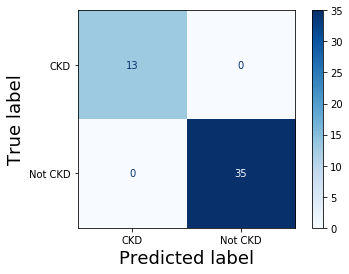

In [79]:
plot_confusion_matrix(logit.best_estimator_, X_test_scaled, y_test, cmap='Blues')


plt.xticks(fontsize=10) #To those particular x-scales we assign particular labels

plt.yticks(fontsize=10)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)

plt.savefig('./conf_mat_logit.png')

In [80]:
import eli5

C:\Users\Pablo Vales\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Pablo Vales\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [81]:
eli5.show_weights(logit.best_estimator_, feature_names=X_test.columns.tolist(), target_names=y_test.value_counts(), 
                 feature_filter=lambda x: x != '<BIAS>')

As we can see, the hypertension and the number of red blood cells are the most relevant features when it comes to predicting a healthy subject. Meanwhile, albumin is a strong predictor on someone who is sick.

# Missing value imputation

In the next section I will apply the same prediction models (decision trees and logistic regression) but imputing NaN values with most frequent labels (for categorical columns) and mean values (for numerical columns). This will be done selectively for both classes, namely, CKD and NotCKD (see function fill_categorical_nan()). For more info and insights see the "Readme" file. 

In [82]:
df.head()

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,CKD
9,53.0,90.0,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.0,107.0,7.2,114.0,3.7,9.5,29.0,12100.0,3.7,yes,yes,no,poor,no,yes,CKD
11,63.0,70.0,1.010,3.0,0.0,abnormal,abnormal,present,notpresent,380.0,60.0,2.7,131.0,4.2,10.8,32.0,4500.0,3.8,yes,yes,no,poor,yes,no,CKD
14,68.0,80.0,1.010,3.0,2.0,normal,abnormal,present,present,157.0,90.0,4.1,130.0,6.4,5.6,16.0,11000.0,2.6,yes,yes,yes,poor,yes,no,CKD
20,61.0,80.0,1.015,2.0,0.0,abnormal,abnormal,notpresent,notpresent,173.0,148.0,3.9,135.0,5.2,7.7,24.0,9200.0,3.2,yes,yes,yes,poor,yes,yes,CKD


In [83]:
df_c.head()


,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [84]:
df_c.dtypes

age                        float64
blood_pres                 float64
specif_grav                float64
albumin                    float64
sugar                      float64
red_blood_cells             object
pus_cell                    object
pus_cell_clumps             object
bacteria                    object
blood_gluc_random          float64
blood_urea                 float64
ser_creatinine             float64
Na                         float64
K                          float64
hemoglobin                 float64
pack_cell_vol              float64
white_blood_cell_count     float64
red_blood_cell_count       float64
hypertension                object
diabetes                    object
coronary_artery_disease     object
appetite                    object
pedal_edema                 object
anemia                      object
label                       object
dtype: object

In [85]:
df_c.isna().sum()

age                          9
blood_pres                  12
specif_grav                 47
albumin                     46
sugar                       49
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_gluc_random           44
blood_urea                  19
ser_creatinine              17
Na                          87
K                           88
hemoglobin                  52
pack_cell_vol               71
white_blood_cell_count     106
red_blood_cell_count       131
hypertension                 2
diabetes                     3
coronary_artery_disease      2
appetite                     1
pedal_edema                  1
anemia                       1
label                        0
dtype: int64

In [86]:
def fill_categorical_nan(df, categorical_columns=None, numerical_columns=None):
    '''This function replaces NaN values selectively for both labels (CKD and NotCKD) with:
    - Most frequent value (for each class) if the column is categorical
    - Mean value (for each class) if the column is numerical'''
    
    healthy_mask = df['label'] == 'notckd'
    sick_mask = df['label'] == 'ckd'
    if categorical_columns:
        print('Filling NaN values on categorical columns')
        for column in categorical_columns:
            
            unique_vals_healthy = df[healthy_mask][column].dropna().value_counts()
            unique_vals_sick = df[sick_mask][column].dropna().value_counts()

            #fill NaN values on healthy subjects on the most common categorical value
            df.loc[healthy_mask, column] = df[healthy_mask][column].fillna(unique_vals_healthy.idxmax()) 

            #fill NaN values on sick subjects on the most common categorical value
            df.loc[sick_mask, column] = df[sick_mask][column].fillna(unique_vals_sick.idxmax()) 
            
    if numerical_columns:
        print('Filling NaN values on numerical columns')
        for column in numerical_columns:
            mean_healthy_val = df[healthy_mask][column].mean()
            mean_sick_val = df[sick_mask][column].mean()
            
            #fill NaN values on healthy subjects with mean value
            df.loc[healthy_mask, column] = df[healthy_mask][column].fillna(mean_healthy_val)
            
            #fill NaN values on sick subjects with mean value
            df.loc[sick_mask, column] = df[sick_mask][column].fillna(mean_sick_val)
            


In [87]:
categorical_cols

['albumin',
 'sugar',
 'red_blood_cells',
 'pus_cell',
 'pus_cell_clumps',
 'bacteria',
 'hypertension',
 'diabetes',
 'coronary_artery_disease',
 'appetite',
 'pedal_edema',
 'anemia',
 'specif_grav']

In [88]:
numerical_cols = list(set(df.columns) - set(categorical_cols))
numerical_cols.remove('label')

In [89]:
numerical_cols

['ser_creatinine',
 'Na',
 'blood_gluc_random',
 'K',
 'red_blood_cell_count',
 'age',
 'hemoglobin',
 'blood_pres',
 'white_blood_cell_count',
 'pack_cell_vol',
 'blood_urea']

In [90]:
fill_categorical_nan(df_c, categorical_cols, numerical_cols)

Filling NaN values on categorical columns
Filling NaN values on numerical columns


In [91]:
df_c.isna().sum()

age                        0
blood_pres                 0
specif_grav                0
albumin                    0
sugar                      0
red_blood_cells            0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
blood_gluc_random          0
blood_urea                 0
ser_creatinine             0
Na                         0
K                          0
hemoglobin                 0
pack_cell_vol              0
white_blood_cell_count     0
red_blood_cell_count       0
hypertension               0
diabetes                   0
coronary_artery_disease    0
appetite                   0
pedal_edema                0
anemia                     0
label                      0
dtype: int64

In [92]:
df_c.head(10)

,age,blood_pres,specif_grav,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes,coronary_artery_disease,appetite,pedal_edema,anemia,label
0,48.0,80.000,1.020,1.0,0.0,normal,normal,notpresent,notpresent,121.000000,36.0,1.2,133.901786,4.878443,15.4,44.0,7800.000000,5.200000,yes,yes,no,good,no,no,ckd
1,7.0,50.000,1.020,4.0,0.0,normal,normal,notpresent,notpresent,175.419811,18.0,0.8,133.901786,4.878443,11.3,38.0,6000.000000,3.945238,no,no,no,good,no,no,ckd
2,62.0,80.000,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.000000,53.0,1.8,133.901786,4.878443,9.6,31.0,7500.000000,3.945238,no,yes,no,poor,no,yes,ckd
3,48.0,70.000,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.000000,3.900000,yes,no,no,poor,yes,yes,ckd
4,51.0,80.000,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.000000,26.0,1.4,133.901786,4.878443,11.6,35.0,7300.000000,4.600000,no,no,no,good,no,no,ckd
5,60.0,90.000,1.015,3.0,0.0,normal,normal,notpresent,notpresent,74.000000,25.0,1.1,142.000000,3.200000,12.2,39.0,7800.000000,4.400000,yes,yes,no,good,yes,no,ckd
6,68.0,70.000,1.010,0.0,0.0,normal,normal,notpresent,notpresent,100.000000,54.0,24.0,104.000000,4.000000,12.4,36.0,9069.536424,3.945238,no,no,no,good,no,no,ckd
7,24.0,79.625,1.015,2.0,4.0,normal,abnormal,notpresent,notpresent,410.000000,31.0,1.1,133.901786,4.878443,12.4,44.0,6900.000000,5.000000,no,yes,no,good,yes,no,ckd
8,52.0,100.000,1.015,3.0,0.0,normal,abnormal,present,notpresent,138.000000,60.0,1.9,133.901786,4.878443,10.8,33.0,9600.000000,4.000000,yes,yes,no,good,no,yes,ckd
9,53.0,90.000,1.020,2.0,0.0,abnormal,abnormal,present,notpresent,70.000000,107.0,7.2,114.000000,3.700000,9.5,29.0,12100.000000,3.700000,yes,yes,no,poor,no,yes,ckd


Let's do one hot encoding:

In [93]:
df_c_enc = pd.get_dummies(df_c, columns=list(set(categorical_cols)-set(['albumin', 'sugar', 'specif_grav'])))

In [94]:
df_c_enc.head()

,age,blood_pres,specif_grav,albumin,sugar,blood_gluc_random,blood_urea,ser_creatinine,Na,K,hemoglobin,pack_cell_vol,white_blood_cell_count,red_blood_cell_count,label,appetite_good,appetite_poor,pus_cell_abnormal,pus_cell_normal,diabetes_no,diabetes_yes,pus_cell_clumps_notpresent,pus_cell_clumps_present,pedal_edema_no,pedal_edema_yes,coronary_artery_disease_no,coronary_artery_disease_yes,bacteria_notpresent,bacteria_present,red_blood_cells_abnormal,red_blood_cells_normal,anemia_no,anemia_yes,hypertension_no,hypertension_yes
0,48.0,80.0,1.020,1.0,0.0,121.000000,36.0,1.2,133.901786,4.878443,15.4,44.0,7800.0,5.200000,ckd,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,0,1
1,7.0,50.0,1.020,4.0,0.0,175.419811,18.0,0.8,133.901786,4.878443,11.3,38.0,6000.0,3.945238,ckd,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0
2,62.0,80.0,1.010,2.0,3.0,423.000000,53.0,1.8,133.901786,4.878443,9.6,31.0,7500.0,3.945238,ckd,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,0,1,1,0
3,48.0,70.0,1.005,4.0,0.0,117.000000,56.0,3.8,111.000000,2.500000,11.2,32.0,6700.0,3.900000,ckd,0,1,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1
4,51.0,80.0,1.010,2.0,0.0,106.000000,26.0,1.4,133.901786,4.878443,11.6,35.0,7300.0,4.600000,ckd,1,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0


In [95]:
X_c, y_c = df_c_enc.drop('label', axis=1), df_c_enc['label']

In [96]:
y_c.replace(['ckd', 'notckd'], ['CKD', 'Not CKD'], inplace=True)

Now that we have the whole dataset (400 rows) without any NaN value let's see how the decision tree and logistic regression behave.

## Decision Tree (2) with NaN imputation:

In [97]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, test_size=.3, random_state=10, stratify=y_c )

In [98]:
parameters = {'max_depth':np.arange(1,10), 'max_leaf_nodes':np.arange(2,10)}

tree_c = DecisionTreeClassifier(criterion='entropy', random_state=10)
grid_search_c = GridSearchCV(estimator=tree_c, param_grid=parameters, cv=5, verbose=1)


grid_search_c.fit(X_c_train, y_c_train)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    4.0s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=10),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             verbose=1)

In [99]:
grid_search_c.best_params_

{'max_depth': 2, 'max_leaf_nodes': 3}

In [100]:
export_graphviz(decision_tree=grid_search_c.best_estimator_,
               out_file='tree_complete.dot', filled=True, 
                feature_names=df_c_enc.drop('label', axis=1).columns)

<img src='./tree_complete_.PNG' width=50%>

In [101]:
y_c_pred = grid_search_c.predict(X_c_test)
confusion_matrix(y_c_test, y_c_pred)

array([[74,  1],
       [ 3, 42]], dtype=int64)

In [102]:
grid_search_c.classes_

array(['CKD', 'Not CKD'], dtype=object)

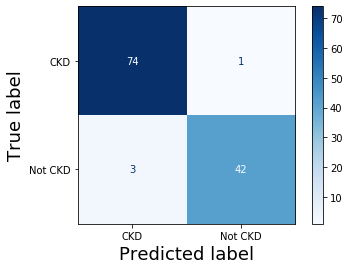

In [103]:
plot_confusion_matrix(grid_search_c.best_estimator_, X_c_test, y_c_test, cmap='Blues')


plt.xticks(fontsize=10) #To those particular x-scales we assign particular labels

plt.yticks(fontsize=10)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)

plt.savefig('./conf_mat_dec_tree_2.png')

In [104]:
accuracy_score(y_c_test, y_c_pred)

0.9666666666666667

# Logistic regression (2) with Nan imputation:

In [105]:
params_logit = {'C':[0.01, 0.1, 1, 10, 100]}
clf_c = LogisticRegression()
logit_c = GridSearchCV(clf, param_grid=params_logit, cv=5, n_jobs=-1, verbose=1)
scaler = StandardScaler().fit(X_c_train)
X_c_train_scaled = scaler.transform(X_c_train)
logit_c.fit(X_c_train_scaled, y_c_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, verbose=1)

In [106]:
logit_c.best_params_

{'C': 1}

In [107]:
logit_c.best_score_

0.9892857142857142

In [108]:
X_c_test_scaled = StandardScaler().fit_transform(X_c_test)

In [109]:
y_c_logit_pred = logit_c.predict(X_c_test_scaled)
confusion_matrix(y_c_test, y_c_logit_pred)

array([[75,  0],
       [ 0, 45]], dtype=int64)

In [110]:
logit_c.classes_

array(['CKD', 'Not CKD'], dtype=object)

In [111]:
accuracy_score(y_c_test, y_c_logit_pred)

1.0

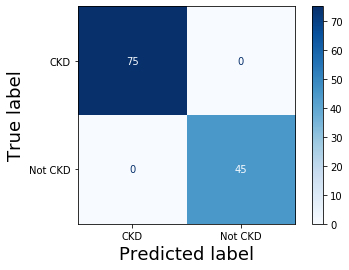

In [112]:
plot_confusion_matrix(logit_c.best_estimator_, X_c_test_scaled, y_c_test, cmap='Blues')


plt.xticks(fontsize=10) #To those particular x-scales we assign particular labels

plt.yticks(fontsize=10)

plt.xlabel('Predicted label', fontsize=18)
plt.ylabel('True label', fontsize=18)

plt.savefig('./conf_mat_logit_2.png')

In [113]:
y_test.value_counts()

Not CKD    35
CKD        13
Name: label, dtype: int64

In [114]:
eli5.show_weights(logit_c.best_estimator_, feature_names=X_c_test.columns.tolist(), target_names=y_test.value_counts(),
                     feature_filter=lambda x: x != '<BIAS>')

Weight?,Feature
+1.738,specif_grav
+1.304,hemoglobin
+1.192,red_blood_cell_count
+0.928,pack_cell_vol
+0.618,Na
+0.471,hypertension_no
+0.465,diabetes_no
+0.388,red_blood_cells_normal
+0.234,pus_cell_normal
+0.194,pedal_edema_no
